In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import warnings
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Set to the number of physical cores


In [5]:
# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [6]:
# Load dataset
data = pd.read_csv("Crop_recommendation.csv")

In [7]:
# Encode labels
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [8]:
# Splitting data
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [10]:
# Feature Importance using RandomForest
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
feature_importance = pd.Series(RF.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
 rainfall       0.223089
humidity       0.208644
K              0.175649
P              0.146791
N              0.105583
temperature    0.080240
ph             0.060004
dtype: float64


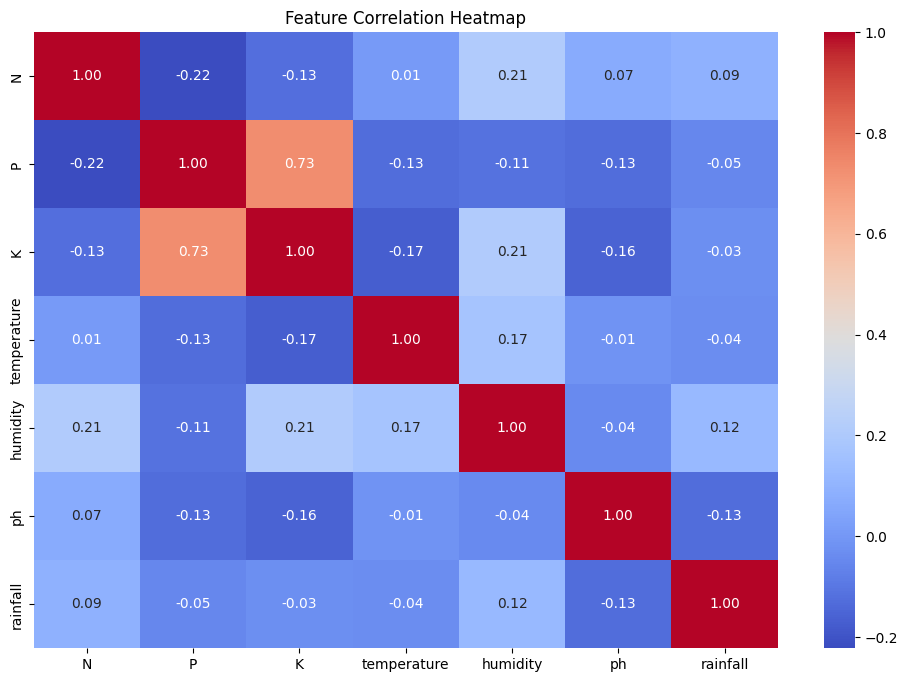

In [11]:
# Drop least important features (if necessary)
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# Hyperparameter tuning for XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
xgb_best = grid_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
XGBoost Accuracy: 0.9260869565217391


In [13]:
# LightGBM Model
lgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))

LightGBM Accuracy: 0.9195652173913044


In [14]:
# Stacking Model (Combining SVM, LightGBM, and XGBoost)
base_learners = [
    ('svm', SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)),
    ('lgbm', lgbm_model)
]
stk_clf = StackingClassifier(estimators=base_learners, final_estimator=xgb_best, passthrough=True)
stk_clf.fit(X_train, y_train)
y_pred_stack = stk_clf.predict(X_test)
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stack))

Stacking Model Accuracy: 0.9782608695652174


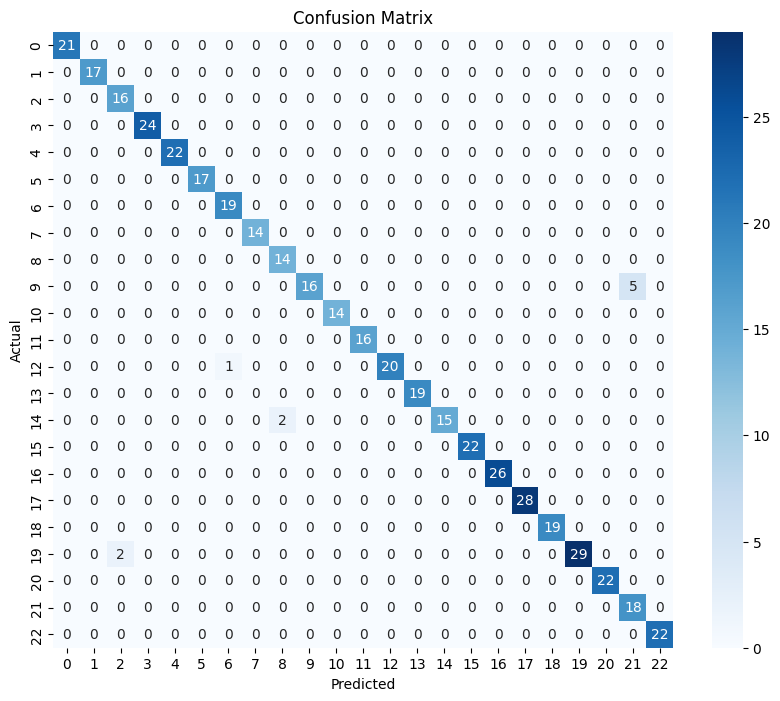

In [15]:
# Confusion Matrix for best model
best_pred = y_pred_stack
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Classification report
print(classification_report(y_test, best_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        17
           2       0.89      1.00      0.94        16
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        17
           6       0.95      1.00      0.97        19
           7       1.00      1.00      1.00        14
           8       0.88      1.00      0.93        14
           9       1.00      0.76      0.86        21
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        16
          12       1.00      0.95      0.98        21
          13       1.00      1.00      1.00        19
          14       1.00      0.88      0.94        17
          15       1.00      1.00      1.00        22
          16       1.00      1.00      1.00        26
          17       1.00    

In [17]:
# Function to predict crop
input_data = pd.DataFrame([[99, 39, 19, 13.87, 68, 6.5, 87]], columns=X.columns)
predicted_crop = le.inverse_transform(stk_clf.predict(input_data))
print("Recommended Crop:", predicted_crop[0])

Recommended Crop: maize


In [18]:
train_accuracy = stk_clf.score(X_train, y_train)
test_accuracy = stk_clf.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_accuracy - test_accuracy > 0.05:
    print("⚠️ Possible overfitting detected!")


Training Accuracy: 0.9489
Test Accuracy: 0.9783


In [19]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(stk_clf, X_train, y_train, cv=5)
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")
print(f"Cross-validation standard deviation: {cv_scores.std():.4f}")


Cross-validation mean accuracy: 0.9742
Cross-validation standard deviation: 0.0083


In [21]:
import pickle

# Save the trained stacking model
with open("crop_recommendation.pkl", "wb") as f:
    pickle.dump(stk_clf, f)

# Save the label encoder to convert predictions back to crop names
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model and Label Encoder Saved Successfully!")


✅ Model and Label Encoder Saved Successfully!
